In [1]:
# pip install pybaseball
# pip install lightgbm

The goal of this analysis is to predict the probability of George Springer swinging at a particular pitch. The probability of the batter swinging at the pitch is determined using features such as: characteristics of the pitch (speed, horizontal and vertical break, pitch type), at-bat situation (number of balls and strikes) and previous pitch faced by the batter.

There are several applications of this study, such as understanding the areas or characteristics of the kind of pitches the batter has a high probability of swinging at. This could then be used for hitter scouting reports used by pitchers. Alternatively, the batter can also use this analysis to better understand their game and identify areas of improvement.

While this particular study is limited to Blue Jays' George Springer, it can be reproduced for different players as well. Additionally, a similar study from a pitcher's perspective can also be carried out to understand the type of pitches where the pitcher is getting the batter to swing.

# Data Collection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_batter, statcast_pitcher, playerid_lookup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


pd.set_option('display.max_columns', None)

In [3]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

The play-by-play data used in this study is gathered from Python's pybaseball library.

In [4]:
#Find the player for whom you want to generate the swing predictions
playerid_lookup('springer','george')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,springer,george,543807,sprig001,springe01,12856,2014.0,2023.0


In [5]:
#Get the pitch-by-pitch data for George Springer over the last 5 years using his key_mlbam
data_complete = statcast_batter('2018-01-01', '2022-12-31', 543807)

Gathering Player Data


In [6]:
data_complete.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,SL,2022-10-08,89.6,2.76,6.07,"Springer, George",543807,592662,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,George Springer strikes out swinging.,F,R,L,TOR,SEA,S,2.0,NaN,2,2,2022,-0.31,0.63,-1.38,1.47,NaN,669289.0,NaN,0,3,Bot,NaN,NaN,NaN,NaN,663728,NaN,NaN,-9.568366,-130.091501,-6.709484,-1.539466,26.308525,-23.797767,3.50,1.59,NaN,NaN,NaN,89.8,2346.0,6.5,715766,592662,663728,664034,624428,553993,641487,672284,677594,571745,54.05,NaN,NaN,0.0,1.0,0.0,0.0,NaN,21,5,Slider,2,0,2,0,0,2,2,0,Standard,Standard,139.0,-0.029,-0.360
1,SL,2022-10-08,89.7,2.55,5.98,"Springer, George",543807,592662,NaN,ball,NaN,NaN,NaN,NaN,13.0,George Springer strikes out swinging.,F,R,L,TOR,SEA,B,NaN,NaN,1,2,2022,-0.10,0.91,-1.78,1.26,NaN,669289.0,NaN,0,3,Bot,NaN,NaN,NaN,NaN,663728,NaN,NaN,-10.502465,-130.206086,-7.669647,0.916361,25.737855,-20.300743,3.41,1.59,NaN,NaN,NaN,90.2,2284.0,6.6,715766,592662,663728,664034,624428,553993,641487,672284,677594,571745,53.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,4,Slider,2,0,2,0,0,2,2,0,Standard,Standard,145.0,0.000,0.045
2,SL,2022-10-08,88.7,2.78,5.91,"Springer, George",543807,592662,NaN,blocked_ball,NaN,NaN,NaN,NaN,13.0,George Springer strikes out swinging.,F,R,L,TOR,SEA,B,NaN,NaN,0,2,2022,-0.24,0.87,-0.57,0.54,NaN,669289.0,NaN,0,3,Bot,NaN,NaN,NaN,NaN,663728,NaN,NaN,-7.733192,-128.793060,-8.962572,-1.162448,25.540160,-20.837412,3.38,1.59,NaN,NaN,NaN,89.4,2224.0,6.7,715766,592662,663728,664034,624428,553993,641487,672284,677594,571745,53.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,3,Slider,2,0,2,0,0,2,2,0,Standard,Standard,141.0,0.000,0.034
3,FF,2022-10-08,93.5,2.70,6.14,"Springer, George",543807,592662,NaN,foul,NaN,NaN,NaN,NaN,1.0,George Springer strikes out swinging.,F,R,L,TOR,SEA,S,NaN,NaN,0,1,2022,0.35,1.74,-0.59,3.25,NaN,669289.0,NaN,0,3,Bot,NaN,NaN,NaN,NaN,663728,NaN,NaN,-9.302148,-135.735435,-5.531029,6.457557,30.301467,-9.668259,3.50,1.59,198.0,72.8,23.0,93.8,2256.0,6.7,715766,592662,663728,664034,624428,553993,641487,672284,677594,571745,53.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,2,4-Seam Fastball,2,0,2,0,0,2,2,0,Standard,Standard,148.0,0.000,-0.076
4,SL,2022-10-08,88.4,2.69,6.13,"Springer, George",543807,592662,NaN,foul,NaN,NaN,NaN,NaN,4.0,George Springer strikes out swinging.,F,R,L,TOR,SEA,S,NaN,NaN,0,0,2022,-0.15,0.78,-0.72,2.42,NaN,669289.0,NaN,0,3,Bot,NaN,NaN,NaN,NaN,663728,NaN,NaN,-8.032773,-128.467752,-4.591871,-0.011973,26.023548,-22.721527,3.50,1.59,8.0,79.3,-17.0,88.7,2276.0,6.5,715766,592662,663728,664034,624428,553993,641487,672284,677594,571745,53.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,1,Slider,2,0,2,0,0,2,2,0,Standard,Standard,144.0,0.000,-0.056


In [7]:
data_complete.shape

(10383, 92)

# Feature Selection & Data Pre-processing

In [8]:
data_complete.description.unique()

array(['swinging_strike', 'ball', 'blocked_ball', 'foul', 'hit_into_play',
       'hit_by_pitch', 'called_strike', 'pitchout', 'foul_tip',
       'swinging_strike_blocked'], dtype=object)

We need to filter out certain pitches where the objective of the pitch is not to get the batter to swing. For example, we see that the dataset includes 'pitchout' pitches where the intent of the pitcher is to get a base runner out, instead of getting Springer to swing at the pitch.

In [9]:
data_complete = data_complete.loc[data_complete.description!='pitchout']
data_complete.shape

(10380, 92)

To begin with, we will be predicting whether George Springer is likely to swing at a pitch based on the following features:
1. **Location of the pitch**: 
    * plate_x, plate_z -> represent the horizontal and vertical position of the ball when it crosses home plate from the catcher's perspective
2. **Speed of the pitch**: 
    * release_speed -> out of hand pitch velocity
    * vx0, vy0, vz0 -> velocity of the pitch in x,y and z dimension determined at y = 50 feet
3. **Vertical and Horizontal break of the pitch**:
    * pfx_x, pfx_z -> horizontal and vertical movement from the catcher's perspective
4. **The situation**:
    * strikes, balls -> pre-pitch number of strikes and balls in count
5. **Details about the pitch**: 
    * p_throws (hand the pitcher throws with)  
6. **Details about the previous pitch**:
    * what was the previous pitch thrown

In [10]:
data = data_complete[['game_date','plate_x','plate_z','release_speed','p_throws','pfx_x','pfx_z','vx0','vy0','vz0','strikes','balls','description','pitch_type','pitch_number','pitcher']].copy()
print(data.shape)
data.head()

(10380, 16)


,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher
0,2022-10-08,-1.38,1.47,89.6,L,-0.31,0.63,-9.568366,-130.091501,-6.709484,2,2,swinging_strike,SL,5,592662
1,2022-10-08,-1.78,1.26,89.7,L,-0.10,0.91,-10.502465,-130.206086,-7.669647,2,1,ball,SL,4,592662
2,2022-10-08,-0.57,0.54,88.7,L,-0.24,0.87,-7.733192,-128.793060,-8.962572,2,0,blocked_ball,SL,3,592662
3,2022-10-08,-0.59,3.25,93.5,L,0.35,1.74,-9.302148,-135.735435,-5.531029,1,0,foul,FF,2,592662
4,2022-10-08,-0.72,2.42,88.4,L,-0.15,0.78,-8.032773,-128.467752,-4.591871,0,0,foul,SL,1,592662


### Feature Engineering

In [11]:
#Creating a target variable 'swing' which will represent if George Springer swung or not
data['swing'] = 1

In [12]:
data.description.unique()

array(['swinging_strike', 'ball', 'blocked_ball', 'foul', 'hit_into_play',
       'hit_by_pitch', 'called_strike', 'foul_tip',
       'swinging_strike_blocked'], dtype=object)

In [13]:
#Update the swing column to 0 for pitches where George Springer did not swing
data['swing'] = np.where(data.description.isin(['ball','blocked_ball','hit_by_pitch','called_strike']), 0, 1)
data.head()

,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher,swing
0,2022-10-08,-1.38,1.47,89.6,L,-0.31,0.63,-9.568366,-130.091501,-6.709484,2,2,swinging_strike,SL,5,592662,1
1,2022-10-08,-1.78,1.26,89.7,L,-0.10,0.91,-10.502465,-130.206086,-7.669647,2,1,ball,SL,4,592662,0
2,2022-10-08,-0.57,0.54,88.7,L,-0.24,0.87,-7.733192,-128.793060,-8.962572,2,0,blocked_ball,SL,3,592662,0
3,2022-10-08,-0.59,3.25,93.5,L,0.35,1.74,-9.302148,-135.735435,-5.531029,1,0,foul,FF,2,592662,1
4,2022-10-08,-0.72,2.42,88.4,L,-0.15,0.78,-8.032773,-128.467752,-4.591871,0,0,foul,SL,1,592662,1


In [14]:
data.swing.value_counts()

0    5537
1    4843
Name: swing, dtype: int64

The dataset in fairly balanced in terms of pitches at which George Springer did and did not swing. As a result, no class balancing techniques such as oversampling or undersampling is required for our analysis.

In [15]:
#Reverse the order of the data to get the data in chronological order (currently the most recent at bat is on top)
data = data.iloc[::-1].reset_index(drop=True)
data.head()

,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher,swing
0,2018-02-25,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,0,0,called_strike,NaN,1,571945,0
1,2018-02-25,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,1,0,called_strike,NaN,2,571945,0
2,2018-02-25,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,2,0,called_strike,NaN,3,571945,0
3,2018-02-25,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,0,0,swinging_strike,NaN,1,594577,1
4,2018-02-25,NaN,NaN,NaN,R,NaN,NaN,NaN,NaN,NaN,1,0,foul,NaN,2,594577,1


In [16]:
#Check the number of records with a missing value for each of the features
data.isna().sum()

game_date          0
plate_x          329
plate_z          329
release_speed    329
p_throws           0
pfx_x            329
pfx_z            329
vx0              329
vy0              329
vz0              329
strikes            0
balls              0
description        0
pitch_type       332
pitch_number       0
pitcher            0
swing              0
dtype: int64

We notice that the number of records for which values such as plate_x, plate_z, pfx_x, pfx_z, vx0, vy0 and vz0 are missing is the same. For now, we can simply drop these records instead of imputing the values, which might add a bias to the dataset. If the number of records with missing values was very high, we can explore other methods such as KNN or MICE Imputation.

In [17]:
#Remove records which have a missing value for plate_x, plate_z, pitch_type or release speed
data = data.dropna(subset = ['plate_x', 'plate_z', 'pitch_type', 'release_speed'])
print(data.shape)
data.isna().sum()

(10048, 17)


game_date        0
plate_x          0
plate_z          0
release_speed    0
p_throws         0
pfx_x            0
pfx_z            0
vx0              0
vy0              0
vz0              0
strikes          0
balls            0
description      0
pitch_type       0
pitch_number     0
pitcher          0
swing            0
dtype: int64

In [18]:
#Create the previous pitch column by shifting the pitch_type variable
data['prev_pitch'] = data.groupby('game_date')['pitch_type'].shift(1)
data['prev_pitch'] = data['prev_pitch'].fillna('first')
data.head(20)

,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher,swing,prev_pitch
106,2018-03-26,1.20,3.79,85.1,L,-0.17,1.14,-3.616514,-124.076887,-1.955041,0,0,ball,FF,1,608718,0,first
107,2018-03-26,-0.42,2.92,90.8,R,-0.60,1.19,3.319773,-132.137317,-3.996909,0,0,foul,FS,1,502026,1,FF
108,2018-03-26,0.45,2.14,79.3,L,0.82,1.10,-6.831929,-115.341286,-4.464681,0,1,hit_into_play,CH,2,608718,1,FS
109,2018-03-26,-0.39,1.87,90.8,R,-1.26,0.59,5.069485,-132.131180,-4.835400,1,0,hit_into_play,FS,2,502026,1,CH
110,2018-03-26,0.58,3.17,71.1,L,-0.91,-0.23,-3.051940,-103.530645,1.580800,0,0,called_strike,CU,1,608718,0,FS
111,2018-03-26,0.44,1.71,72.9,L,-0.79,-0.38,-3.368657,-106.254277,-1.529610,1,0,ball,CU,2,608718,0,CU
112,2018-03-26,-0.09,4.00,86.7,L,-0.10,1.09,-6.767548,-126.353066,-1.670366,1,1,swinging_strike,FF,3,608718,1,CU
113,2018-03-26,-0.46,3.28,86.5,L,-0.26,0.90,-7.207556,-125.940664,-2.889590,2,1,foul,FF,4,608718,1,FF
114,2018-03-26,2.14,2.62,79.3,L,0.89,0.97,-3.112843,-115.552694,-3.297421,2,1,ball,CH,5,608718,0,FF
115,2018-03-26,1.16,3.11,87.0,L,-0.19,0.89,-3.465870,-126.868278,-3.393535,2,2,ball,FF,6,608718,0,CH


It should be noted that we have grouped the data by game_date before shifting the values of the pitch_type. This has been done because we make an assumption that the pitch type of a pitch that George Springer faced today, will not impact his decision to swing or not swing on the next day's first pitch. Instead, the first pitch that George Springer faces every game has been given its own separate category ('first').

In [19]:
data.pitch_type.unique()

array(['FF', 'FS', 'CH', 'CU', 'SI', 'FC', 'SL', 'KC', 'ST', 'SV', 'KN',
       'EP', 'CS', 'FO', 'FA'], dtype=object)

In [20]:
#The pitchtype currently contains 15 different categories which can be split into 3 major categories. 
#This has been done to avoid creating a seperate dummy variable for each particular pitch type.
fastball = ['FF','SI', 'FC', 'FA']
breaking = ['CU','SL','KC','KN','FS', 'ST', 'SV', 'CS']
offspeed = ['CH','FO','EP']

data['pitch_type'] = np.where(data['pitch_type'].isin(fastball), 'fastball', data['pitch_type'])
data['pitch_type'] = np.where(data['pitch_type'].isin(breaking), 'breaking', data['pitch_type'])
data['pitch_type'] = np.where(data['pitch_type'].isin(offspeed), 'offspeed', data['pitch_type'])

data['prev_pitch'] = np.where(data['prev_pitch'].isin(fastball), 'fastball', data['prev_pitch'])
data['prev_pitch'] = np.where(data['prev_pitch'].isin(breaking), 'breaking', data['prev_pitch'])
data['prev_pitch'] = np.where(data['prev_pitch'].isin(offspeed), 'offspeed', data['prev_pitch'])

print(data.pitch_type.unique())
print(data.prev_pitch.unique())

['fastball' 'breaking' 'offspeed']
['first' 'fastball' 'breaking' 'offspeed']


In [21]:
#Create dummy columns for the categorical variables: pitch_type, prev_pitch and p_throws
data_dummies = pd.get_dummies(data, columns=['pitch_type', 'prev_pitch', 'p_throws'], drop_first=True)
data_dummies.head()

,game_date,plate_x,plate_z,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_number,pitcher,swing,pitch_type_fastball,pitch_type_offspeed,prev_pitch_fastball,prev_pitch_first,prev_pitch_offspeed,p_throws_R
106,2018-03-26,1.20,3.79,85.1,-0.17,1.14,-3.616514,-124.076887,-1.955041,0,0,ball,1,608718,0,1,0,0,1,0,0
107,2018-03-26,-0.42,2.92,90.8,-0.60,1.19,3.319773,-132.137317,-3.996909,0,0,foul,1,502026,1,0,0,1,0,0,1
108,2018-03-26,0.45,2.14,79.3,0.82,1.10,-6.831929,-115.341286,-4.464681,0,1,hit_into_play,2,608718,1,0,1,0,0,0,0
109,2018-03-26,-0.39,1.87,90.8,-1.26,0.59,5.069485,-132.131180,-4.835400,1,0,hit_into_play,2,502026,1,0,0,0,0,1,1
110,2018-03-26,0.58,3.17,71.1,-0.91,-0.23,-3.051940,-103.530645,1.580800,0,0,called_strike,1,608718,0,0,0,0,0,0,0


In [22]:
#Create the features and target dataset for out model
X = data_dummies[['plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'strikes', 'balls', 'pitch_type_fastball', 'pitch_type_offspeed', 'prev_pitch_fastball', 'prev_pitch_first', 'prev_pitch_offspeed', 'p_throws_R']].copy()
y = data_dummies[['swing']]

In [23]:
print(X.shape)
print(y.shape)

(10048, 16)
(10048, 1)


In [24]:
X.describe()

,plate_x,plate_z,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,pitch_type_fastball,pitch_type_offspeed,prev_pitch_fastball,prev_pitch_first,prev_pitch_offspeed,p_throws_R
count,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000,10048.000000
mean,0.169211,2.277867,89.168332,-0.089112,0.703264,2.438337,-129.619201,-4.362253,0.869327,0.943969,0.596437,0.104299,0.565884,0.056728,0.094546,0.714570
std,0.864922,0.958544,5.808698,0.889801,0.717636,6.064780,8.410988,3.036392,0.819868,0.994633,0.490636,0.305664,0.495665,0.231333,0.292602,0.451641
min,-3.370000,-2.800000,51.200000,-1.950000,-1.870000,-15.602375,-149.029374,-16.208240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.420000,1.660000,85.000000,-0.840000,0.270000,-2.552087,-136.205560,-6.463147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.195000,2.270000,90.100000,-0.100000,0.800000,4.288588,-130.924417,-4.464639,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.760000,2.890000,93.700000,0.600000,1.290000,6.881461,-123.614959,-2.419626,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,4.610000,9.390000,102.500000,2.150000,2.140000,16.248667,-73.889640,11.092505,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We notice that the range of plate_x (-3 to 4.6) varies significantly from that of the release speed (51 to 102). As a result, will standardize the features to ensure that all features are given an equal importance. Since the data contains a mix of numerical and binary variables, we will use a Min-Max Scaler.

In [25]:
#Create the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Standardize the features
minmax = MinMaxScaler()
X_train_scaled = pd.DataFrame(minmax.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(minmax.transform(X_test), columns=X.columns)

# Creating the ML Model

### I. Create a base logistic regression model

To begin with, we will create a simple logistic regression model that can be used as our base model. The logistic regression model will help us generate an initial intuition of how the features impact the probability of swing, and create a benchmark that our final model must beat.

In [26]:
#Train the Logit model using the training dataset
logreg = sm.Logit(y_train.values.reshape(-1,1), X_train_scaled).fit()

Optimization terminated successfully.
         Current function value: 0.663784
         Iterations 5


In [27]:
#Print the results of the Logit Model
print(logreg.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8038
Model:                          Logit   Df Residuals:                     8022
Method:                           MLE   Df Model:                           15
Date:                Mon, 11 Sep 2023   Pseudo R-squ.:                 0.03862
Time:                        10:53:56   Log-Likelihood:                -5335.5
converged:                       True   LL-Null:                       -5549.8
Covariance Type:            nonrobust   LLR p-value:                 6.347e-82
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
plate_x                -0.4384      0.338     -1.298      0.194      -1.101       0.224
plate_z                 4.0585      0.665      6.100      0.000       2.754       5.363
release_speed   

Our initial analysis shows that:
1. Certain features such as plate_z, release_speed, vy0, strikes, balls, and pitch_type_offspeed have a very small z score, indicating that they are statistically significant in determining whether George Springer will swing at a given pitch.
2. Higher vertical position of ball, horizontal movement, velocity of pitch in x-dimension, and strikes are all associated with a higher probability of George Springer swinging at a pitch.
3. Lower horizontal position of ball, release speed, and velocity of pitch in y-direction are all associated with a higher probability of George Springer swinging at a pitch.

In [28]:
#Predict the probabilities for the test set
logreg_predictions = logreg.predict(X_test_scaled)
logreg_predictions = list(map(round, logreg_predictions))

In [29]:
# Create the Classification Report for the test set predictions
print(classification_report(y_test, logreg_predictions)) 
  
# Determine the test set accuracy of the model
print('Test accuracy = ', round(accuracy_score(y_test, logreg_predictions),3))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1080
           1       0.60      0.49      0.54       930

    accuracy                           0.61      2010
   macro avg       0.61      0.61      0.60      2010
weighted avg       0.61      0.61      0.61      2010

Test accuracy =  0.614


### II. Create a LightGBM Classifier Model

We will now train and test a LightGBM Classifier model to see if it can perform better than the base logistic regression model

In [30]:
#Create a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 6, 8, 10, 12],
    'min_child_samples': [1, 5, 10, 15, 20]
}

#Create a lightGBM model and train it using the training set
gbm = lgb.LGBMClassifier(verbose=-1)

#Create the gridsearch model
model = GridSearchCV(estimator=gbm, param_grid=param_grid, cv = 5)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-1),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_child_samples': [1, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 150, 200, 250, 300]})

In [31]:
best_params = model.best_params_
print(best_params)

best_model = model.best_estimator_

{'learning_rate': 0.05, 'max_depth': 4, 'min_child_samples': 5, 'n_estimators': 300}


In [32]:
#Predict the swing probabilities for the test set
gbm_pred=best_model.predict(X_test_scaled)

In [33]:
# Create the Classification Report for the test set predictions
print(classification_report(y_test, gbm_pred)) 
  
# Determine the test set accuracy of the model
print('Test accuracy = ', round(accuracy_score(y_test, gbm_pred),3))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1080
           1       0.78      0.81      0.79       930

    accuracy                           0.81      2010
   macro avg       0.81      0.81      0.81      2010
weighted avg       0.81      0.81      0.81      2010

Test accuracy =  0.806


We can see that the performance of the LightGBM model is much better than that of our base logistic regression model. The model has an overall accuracy of 80%. Additionally, the precision and recall for both the classes (swing vs. no swing) is also ~80%.

# Applications

The initial logistic regression model helped us form an early intuition about the features that impacted George Springer's probability of swinging, along with understanding the charactertistics of pitches at which he was more or less likely to swing. However, using this model to predict if George Springer is likely to swing at a specific pitch is not the most optimal application. Instead, we can use visualizations to help us understand zones and attributes along with the swing probabilities.

For this, we start by focussing on Springer's probability of swinging at pitches thrown by pitcher 501985 (Mike Minor)

In [34]:
#Filter out the records to only includes pitches thrown by player id 501985
data_vis = data_dummies.loc[data_dummies.pitcher == 501985].copy()

#Separate the features and target variables
X_vis = data_vis[['plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'strikes', 'balls', 'pitch_type_fastball', 'pitch_type_offspeed', 'prev_pitch_fastball', 'prev_pitch_first', 'prev_pitch_offspeed', 'p_throws_R']].copy()
y_vis = data_vis[['swing']]

#Scale the features
minmax = MinMaxScaler()
X_vis_scaled = pd.DataFrame(minmax.fit_transform(X_vis), columns=X_vis.columns)

#Build and train the lightGBM model
gbm_vis = lgb.LGBMClassifier()
gbm_vis.fit(X_vis_scaled, y_vis)

#Predict the swing probabilities for all the records
gbm_vis_prob = gbm_vis.predict_proba(X_vis_scaled)[:,1]

[LightGBM] [Info] Number of positive: 59, number of negative: 76
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 135, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437037 -> initscore=-0.253196
[LightGBM] [Info] Start training from score -0.253196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [35]:
#Create the final dataset which includes the characteristics of the pitch + probability of Springer swinging at them
data_vis = data.loc[data.pitcher == 501985].copy()
data_vis['swing_probability'] = gbm_vis_prob
print(data_vis.shape)
data_vis.head()

(135, 19)


,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher,swing,prev_pitch,swing_probability
174,2018-04-01,-1.39,2.29,93.7,L,0.57,1.50,-7.388648,-136.076844,-7.266864,0,0,ball,fastball,1,501985,0,first,0.031830
175,2018-04-01,-1.47,2.91,93.6,L,0.63,1.42,-7.454981,-135.883144,-5.340366,0,1,ball,fastball,2,501985,0,fastball,0.064429
176,2018-04-01,-0.25,1.52,93.5,L,0.87,1.52,-5.147271,-135.779976,-9.127447,0,2,ball,fastball,3,501985,0,fastball,0.091042
177,2018-04-01,-0.61,2.15,93.6,L,0.88,1.61,-5.956631,-135.987234,-7.776496,0,3,called_strike,fastball,4,501985,0,fastball,0.205221
178,2018-04-01,-0.08,1.34,94.1,L,0.93,1.53,-4.534941,-136.532076,-9.745281,1,3,ball,fastball,5,501985,0,fastball,0.157434


Text(0.5, 1.0, "Springer's probability of swinging based on pitch position")

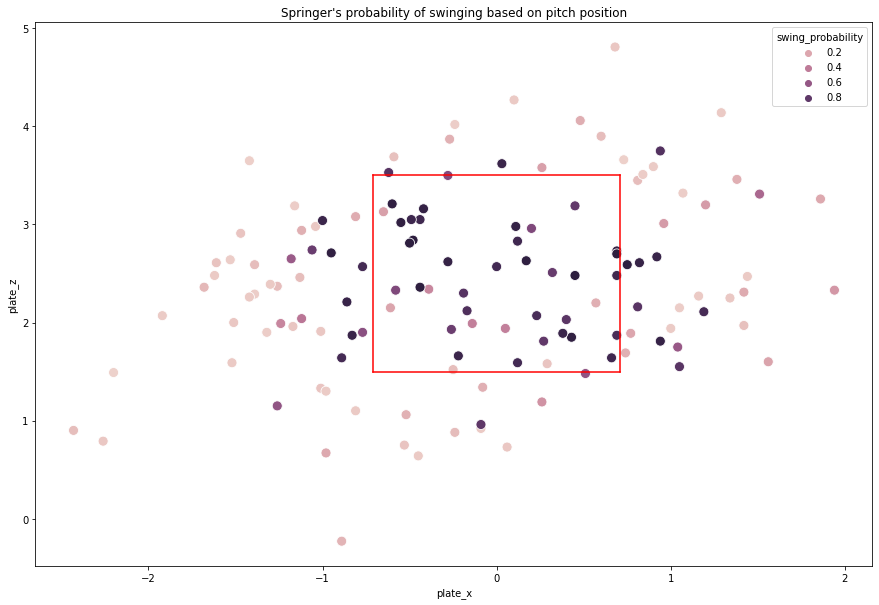

In [37]:
#Plot the position of the pitch when it crosses home plate, along with the probability of Springer swinging at it
plt.figure(figsize=(15,10))
sns.scatterplot(x = data_vis.plate_x, y = data_vis.plate_z, hue = data_vis.swing_probability, s = 100)

#Add the rough strike box (note: Original strike box coordinates will change depending on the height of the player at bat)
plt.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
plt.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
plt.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
plt.plot([0.71, 0.71], [1.50, 3.50], color = 'red')

plt.title("Springer's probability of swinging based on pitch position")

The graph above shows the horizontal and vertical position of the pitch, along with the probability of Springer swinging at the pitch. As expected, we see that the probability of swinging is highest for pitches that are within the strikezone.

Text(0.5, 1.0, "Springer's probability of swinging based on pitch position and pitch type")

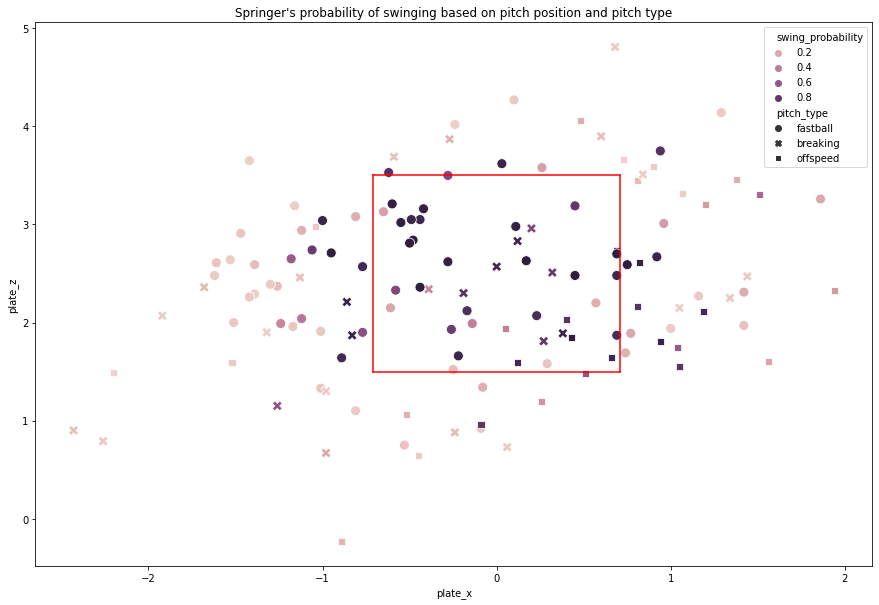

In [38]:
#Plot the position of the pitch when it crosses home plate, along with the probability of Springer swinging at it. 
#Differentiate the pitches based on the pitch type
plt.figure(figsize=(15,10))
sns.scatterplot(x = data_vis.plate_x, y = data_vis.plate_z, hue = data_vis.swing_probability, style=data_vis.pitch_type, s = 100)

#Add the rough strike box (note: Original strike box coordinates will change depending on the height of the player at bat)
plt.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
plt.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
plt.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
plt.plot([0.71, 0.71], [1.50, 3.50], color = 'red')

plt.title("Springer's probability of swinging based on pitch position and pitch type")

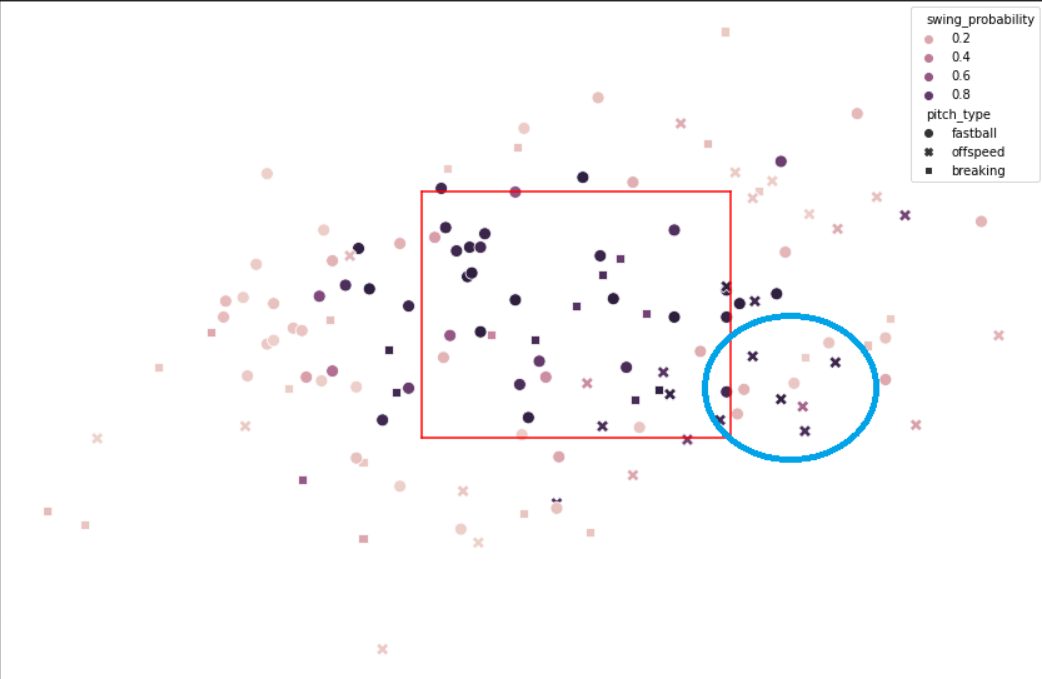

The analysis from the first visualization can be further extended by splitting the pitches based on their type: fastall, offspeed or breaking. The highlighted circle shows that Springer has a higher probability of swinging at pitches outside the strikezone on right side when they are offspeed pitches, as compared to fastball or breaking pitches.

The analysis from the first visualization can be further extended by splitting the pitches based on their type: fastall, offspeed or breaking. The highlighted circle shows that Springer has a higher probability of swinging at pitches outside the strikezone on right side when they are offspeed pitches, as compared to fastball or breaking pitches.

Text(0.5, 1.0, "Springer's probability of swinging based on pitch position and number of strikes")

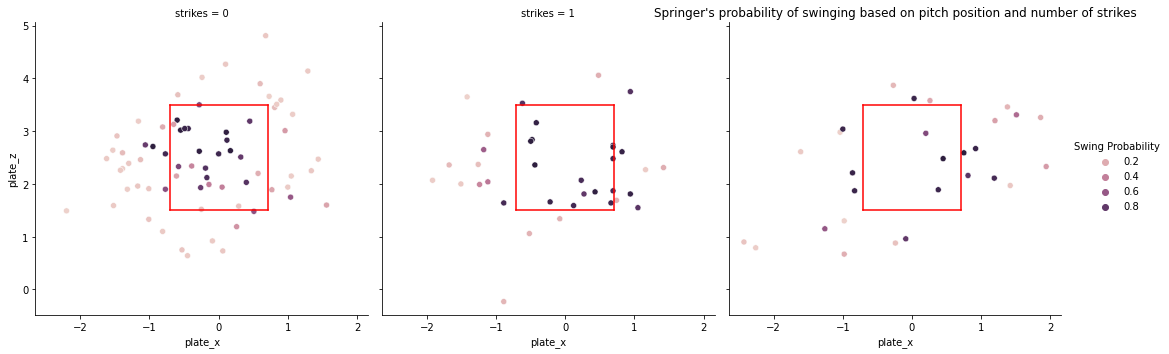

In [39]:
#Visualizing the impact of strikes on Springer's swing predictions
g = sns.FacetGrid(data_vis, col="strikes", aspect=1, height=5)
g.map_dataframe(sns.scatterplot, x="plate_x", y="plate_z", hue="swing_probability")
ax1, ax2, ax3 = g.axes[0]
ax1.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
ax1.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
ax1.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
ax1.plot([0.71, 0.71], [1.50, 3.50], color = 'red')
ax2.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
ax2.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
ax2.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
ax2.plot([0.71, 0.71], [1.50, 3.50], color = 'red')
ax3.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
ax3.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
ax3.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
ax3.plot([0.71, 0.71], [1.50, 3.50], color = 'red')
g.add_legend(title = 'Swing Probability')

plt.title("Springer's probability of swinging based on pitch position and number of strikes")

The next visualization compares the difference in Springer's swing probabilities based on the number of current strikes. From the chart, we see that when Springer is on 2 strikes, his probability of swinging at pitches on the right side outside the strikezone increases significantly as compared to when he has no strikes(with no strikes he has ~2% probability of swinging at these pitches).

# Conclusion

The study focussed on predicting the probability of George Springer swinging at a pitch, based on various characteristics of the pitch and the situation within the game. From the study, we were able to identify the key factors that increase/decrease the probability of Springer swinging at a pitch and create a model that can predict this with high accuracy.

The second part of the study focussed on the different ways in which this model could be used by the Blue Jays or the opposing teams. We visualized how factors such as the position of the pitch, the type of pitch and the number of strikes all change the probability of Springer swinging at a pitch. The data could be used by scouts to analyze where a particular pitcher should pitch to Springer, based on the game situation.

This study can be extended in various ways, from exploring the model and insights for different batters and pitchers, or even adding additional features such as the at-bat context (how many players are on base?) or details about the player's previous at-bat.